In [1]:
import os
new_directory = "/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/HACCnPaint/Cores/PaintCores_lcx/"  # Replace with the actual path
os.chdir(new_directory)


import numpy as np
import h5py

# %%
import numexpr
# numexpr.set_num_threads(min(8, numexpr.detect_number_of_cores()))
numexpr.set_num_threads(64)

import time
time0 = time.time()
import glob
import pandas as pd

import matplotlib.pyplot as plt
# import haccytrees.mergertrees
# import pygio


# os.environ["CUDA_32VISIBLE_DEVICES"] = ""



import simulation_models
# import cosmology_utils
# import cores_analysis
import plot_utils
# import lightcone_tree_matching
# import bpl_analysis
import painting
import catalog_io
import yaml_read
import photometry
# import scipy.spatial


%matplotlib inline


# from mpi4py import MPI
from numba import config
config.THREADING_LAYER = 'workqueue'

In [2]:
config = yaml_read.yaml_config('config_LJ.yml')
target_skypatch_id = config['hacc_simulation']['skypatchID']
target_skypatch_id = 4
print(target_skypatch_id)

4


In [3]:
def load_matches_from_h5(output_file):
    combined_data = {}
    with h5py.File(output_file, "r") as f:
        for core_key in f.keys():
            for key in f[core_key].keys():
                if key not in combined_data:
                    combined_data[key] = []
                combined_data[key].append(f[core_key][key][...])
    # Concatenate lists of arrays into single arrays for each key
    for key in combined_data:
        combined_data[key] = np.concatenate(combined_data[key], axis=0)
    return combined_data

output_file = f"../PaintCores_lcx/mocks/finished_mocks/supermock_lightcone_skypatch_{target_skypatch_id}.h5"
# Load matches_for_lc from the HDF5 file
matches_for_lc = load_matches_from_h5(output_file)

print('Available match keys: ', matches_for_lc.keys())
print('Matches: ', matches_for_lc['x'].shape, 'Skypatch: ', target_skypatch_id)

Available match keys:  dict_keys(['central', 'core_state', 'core_tag', 'dec', 'fof_halo_tag', 'merged', 'peak_mass', 'ra', 'rank_peak_mass', 'redshift', 'sfh', 'stellar_mass', 't25_a1', 't50_a1', 'time_infall', 'vx', 'vy', 'vz', 'x', 'y', 'z'])
Matches:  (36067069,) Skypatch:  4


In [4]:
cosmo = simulation_models.get_cosmo(config['hacc_simulation']['name'])

In [5]:
match_redshift = matches_for_lc['redshift']#[:1000]
match_sfh = matches_for_lc['sfh'][:, np.newaxis, :]#[:1000]
central_cond = matches_for_lc['central']
merged_cond = matches_for_lc['merged']

In [6]:
match_sfh.shape, match_redshift.shape, matches_for_lc['peak_mass'].shape, matches_for_lc['stellar_mass'].shape

((36067069, 1, 117), (36067069,), (36067069,), (36067069,))

In [7]:
# central_cond

/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/HACCnPaint/Cores/PaintCores_lcx/plot_utils.py:406: RuntimeWarning: invalid value encountered in log10
  corner.hist2d( x=np.log10(Mpeak),


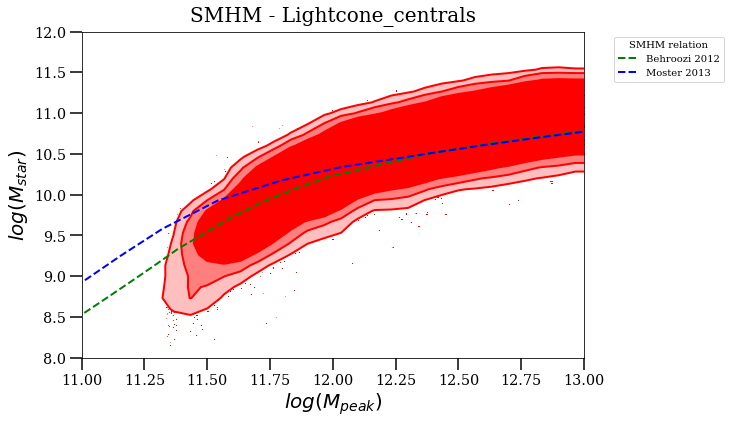

<Figure size 432x288 with 0 Axes>

In [8]:
# plt.hist(np.log10(matches_for_lc['peak_mass']), alpha=0.5, bins=100);
plot_utils.plot_SMHM_comparison(matches_for_lc['peak_mass'][::1], matches_for_lc['stellar_mass'][::1], 'Lightcone_centrals')
# plt.hist(matches_for_lc['redshift'], alpha=0.5, bins=100);
# plot_utils.basemap_plot(matches_for_lc['ra'], matches_for_lc['dec'])
# plt.hist(np.log10(matches_for_lc[0]['stellar_mass']), alpha=0.5, bins=100);
# plt.plot(matches_for_lc['sfh'][0:10].T, alpha=0.5); 
# plt.yscale('log')
# plt.ylim(1e-3, )

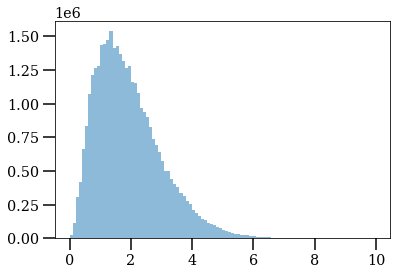

In [9]:
# plt.hist(np.log10(matches_for_lc['peak_mass']), alpha=0.5, bins=100);
# plot_utils.plot_SMHM_comparison(matches_for_lc['peak_mass'], matches_for_lc['stellar_mass'], 'Lightcone_centrals')
plt.hist(matches_for_lc['redshift'], alpha=0.5, bins=100);
# plot_utils.basemap_plot(matches_for_lc['ra'], matches_for_lc['dec'])
# plt.hist(np.log10(matches_for_lc[0]['stellar_mass']), alpha=0.5, bins=100);
# plt.plot(matches_for_lc['sfh'][0:10].T, alpha=0.5);

## Loading paint

In [10]:
def load_matches_from_h5(output_file):
    combined_data = {}
    with h5py.File(output_file, "r") as f:
        for key in f.keys():
            combined_data[key] = f[key][...]  # Read the entire dataset into memory
    return combined_data

In [11]:
output_file = f"../PaintCores_lcx/mocks/paint_models/finished_paints/paint_preds_skypatch_{target_skypatch_id}.h5"

sed_for_lc = load_matches_from_h5(output_file)

print('Available match keys: ', sed_for_lc.keys())
print('Matches: ', sed_for_lc['SED'].shape, 'Skypatch: ', target_skypatch_id)

Available match keys:  dict_keys(['SED', 'core_tag'])
Matches:  (36067069, 1963) Skypatch:  4


In [12]:
sed_for_lc['SED'].shape

(36067069, 1963)

In [13]:
matches_for_lc

{'central': array([0, 1, 1, ..., 1, 1, 1], dtype=int32),
 'core_state': array([2, 0, 0, ..., 0, 0, 0], dtype=int16),
 'core_tag': array([ 616997551291255275, 1562753473039047340, 1058345916727038597, ...,
         220848231972601934,  220830639786557495,  216327383756570634]),
 'dec': array([72.682, 70.188, 81.645, ..., 70.421, 72.401, 72.18 ]),
 'fof_halo_tag': array([ 34567315451,  35260518274,  15953592797, ..., 770056495521,
        694334503558, 683591664184]),
 'merged': array([1, 0, 0, ..., 0, 0, 0], dtype=int32),
 'peak_mass': array([1.538e+13, 2.745e+11, 3.505e+11, ..., 9.432e+13, 4.029e+13,
        1.128e+14], dtype=float32),
 'ra': array([21.336, 15.307, 11.266, ...,  6.547,  6.952, 14.409]),
 'rank_peak_mass': array([1.165e-06, 1.515e-06, 1.927e-06, ..., 2.207e-10, 1.734e-10,
        3.152e-10]),
 'redshift': array([0.116, 0.101, 0.107, ..., 8.695, 8.821, 8.58 ]),
 'sfh': array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 4.966e-01, 1.279e-01,
         1.915e-01],
        [0.000

In [14]:
# adsdsdasdfd

In [15]:
(matches_for_lc['core_tag'] == sed_for_lc['core_tag']).all()

True

In [16]:
dirIn1 = '/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/TrainingData/Data/Damp_red_centrals_100k_z10/'
dirIn2 = '/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/TrainingData/Data/Damp_red_noncentrals_100k_z10/'

nranks = 16
rnd_seed = 42
wave_cen = np.concatenate([np.load(dirIn1 + 'wave_spec' + str(rnd_seed) + '_rank' + str(rank) + '.npy') for rank in range(nranks)], axis=0)
reds_cen = np.concatenate([np.load(dirIn1 +'redshift' + str(rnd_seed) + '_rank' + str(rank) + '.npy') for rank in range(nranks)], axis=0)
wave_unred_cen = wave_cen/(1+reds_cen)[:, np.newaxis]

nranks = 16
rnd_seed = 14
wave_sat = np.concatenate([np.load(dirIn2 + 'wave_spec' + str(rnd_seed) + '_rank' + str(rank) + '.npy') for rank in range(nranks)], axis=0)
reds_sat = np.concatenate([np.load(dirIn2 +'redshift' + str(rnd_seed) + '_rank' + str(rank) + '.npy') for rank in range(nranks)], axis=0)
wave_unred_sat = wave_sat/(1+reds_sat)[:, np.newaxis]

print('(wave_unred_cen[0] - wave_unred_sat[0]).min() = ', (wave_unred_cen[0] - wave_unred_sat[0]).min()) 

wave_unred = wave_unred_cen[0]


def load_wave_unred():
    dirIn1 = '/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/TrainingData/Data/Damp_red_centrals_100k_z10/'
    dirIn2 = '/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/TrainingData/Data/Damp_red_noncentrals_100k_z10/'
    nranks = 16
    rnd_seed = 42
    wave_cen = np.concatenate([np.load(dirIn1 + 'wave_spec' + str(rnd_seed) + '_rank' + str(rank) + '.npy')
                               for rank in range(nranks)], axis=0)
    reds_cen = np.concatenate([np.load(dirIn1 + 'redshift' + str(rnd_seed) + '_rank' + str(rank) + '.npy')
                               for rank in range(nranks)], axis=0)
    wave_unred_cen = wave_cen/(1+reds_cen)[:, np.newaxis]
    nranks = 16
    rnd_seed = 14
    wave_sat = np.concatenate([np.load(dirIn2 + 'wave_spec' + str(rnd_seed) + '_rank' + str(rank) + '.npy')
                               for rank in range(nranks)], axis=0)
    reds_sat = np.concatenate([np.load(dirIn2 + 'redshift' + str(rnd_seed) + '_rank' + str(rank) + '.npy')
                               for rank in range(nranks)], axis=0)
    wave_unred_sat = wave_sat/(1+reds_sat)[:, np.newaxis]
    wave_unred = wave_unred_cen[0]
    return wave_unred

wave_unred = load_wave_unred()

(wave_unred_cen[0] - wave_unred_sat[0]).min() =  -1.4901161193847656e-08


In [17]:
def load_model_and_scalers(scaler_output_path):
    import pickle

    with open(scaler_output_path, 'rb') as f:
        scaler_output = pickle.load(f)
    
    return scaler_output

def unscale_sed(scaler_output, scaled_sed):
    model_output_log = scaler_output.inverse_transform(scaled_sed)
    sed_unscaled = 10**(model_output_log)
    
    return sed_unscaled
    

scaler_output_path = './trained_painting_NNs/eline_output_scale_damp_central_noncentral_z10.pkl'    
scaler_output = load_model_and_scalers(scaler_output_path)

In [18]:
# wave_unred.min(), (wave_unred*(1 + match_redshift[gal_idx])).min(), wave_unred.max(), (wave_unred*(1 + match_redshift[gal_idx])).max()

In [19]:
config['painting_model']['wave_min'], config['painting_model']['wave_max']

(90, 100000)

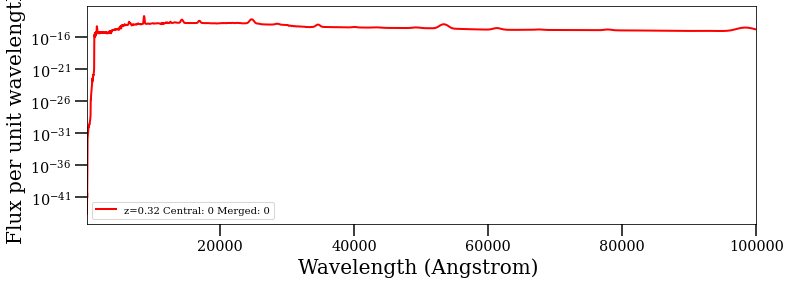

In [20]:
wave_min = config['painting_model']['wave_min']
wave_max = config['painting_model']['wave_max']

wave_min = 90
wave_max = 100000


gal_idx = 32544
each_wave_red = wave_unred*(1 + match_redshift[gal_idx])
each_sed = sed_for_lc['SED'][gal_idx].reshape(-1, 1).T

sed_unscaled = unscale_sed(scaler_output, each_sed)[0]


plt.figure(21, figsize = (12, 4))
plt.plot(each_wave_red, sed_unscaled, color='r', label='z=%.2f'%match_redshift[gal_idx] + ' Central: %d'%central_cond[gal_idx] + ' Merged: %d'%merged_cond[gal_idx]);
plt.xlim(wave_min, wave_max)
plt.ylabel('Flux per unit wavelength')
plt.xlabel('Wavelength (Angstrom) ')
plt.legend()
plt.yscale('log')

In [21]:
np.min(wave_cen, axis=1).max(), wave_min, np.max(wave_cen, axis=1).min(), wave_max

(1000.9834102518313, 90, 100028525.16054355, 100000)

In [22]:
# wave_unred

In [23]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import ListedColormap
from getdist import plots, MCSamples
import corner
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as mcolors  

def plot_SED(pcolor_all, wave_unnred, redshift_in, wave_min, wave_max, plt_title):
    plt.clf()
    plt.close('all')
    
    np.random.seed(1)
    plt.figure(figsize = (12, 4))

    # galID_arr =  np.arange(0, pcolor_all.shape[1])
    galID_arr =  np.random.randint(0, pcolor_all.shape[0], 5)

    colorparams = galID_arr
    colormap = plt.get_cmap('viridis', 10)
    normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))


    for idx, galID in enumerate(galID_arr):
        print(idx, galID)
        print(wave_unnred.shape)

        color = colormap(normalize(galID))

        # wave_mask = np.where( (wave_unnred[0]>wave_min) & (wave_unnred[0]<wave_max))
        wave_mask = np.where( (wave_unnred>wave_min) & (wave_unnred<wave_max))
        # wave_mask = True
        
        each_wave_red = wave_unnred[wave_mask]*(1 + redshift_in[galID])
        
        print(each_wave_red.shape, pcolor_all[galID, wave_mask][0].shape, redshift_in[galID], each_wave_red.shape)

        print('P', pcolor_all[galID, wave_mask].shape)
        # sed_unscaled = unscale_sed(scaler_output, pcolor_all[galID].reshape(-1, 1).T)
        
        # print('S', sed_unscaled.shape)

        plt.plot(each_wave_red, pcolor_all[galID, wave_mask][0],  color = color, alpha=1, label='z=%.2f'%redshift_in[galID]);
        
        # plt.plot(wave, np.median(pcolor_all[:, galID, :].T, axis=1)*1./(4*np.pi*dd1**2),  color = color, alpha=1, linewidth = 0.8, label='z=%.2f'%redshift_in[0, idx]);
        # plt.plot(wave, np.median(pcolor_all[:, galID, :].T, axis=1),  color = color, alpha=1, linewidth = 0.8, linestyle = '-.', label='z=%.2f'%redshift_in[0, idx]);


    plt.ylabel('Flux per unit wavelength')
    plt.xlabel('Wavelength (Angstrom) ')

    plt.yscale('log')
    plt.legend(ncol=1, title='Redshift')
    plt.xlim(wave_min, wave_max)

    # plt.savefig('plots/sed_'+ plt_title +'.png',bbox_inches='tight',dpi = 300)
    plt.show()

In [24]:
sed_for_lc['SED'][0:20].shape, match_redshift[0:20].shape, wave_unred.shape, config['painting_model']['wave_min'], config['painting_model']['wave_max']

((20, 1963), (20,), (1963,), 90, 100000)

In [25]:
sed_unscaled = unscale_sed(scaler_output, sed_for_lc['SED'][0:10])

In [26]:
sed_unscaled.shape, match_redshift.shape

((10, 1963), (36067069,))

0 5
(1963,)
(1212,) (1212,) 0.1273871071370105 (1212,)
P (1, 1212)
1 8
(1963,)
(1212,) (1212,) 0.12457763854374049 (1212,)
P (1, 1212)
2 9
(1963,)
(1212,) (1212,) 0.11834666229058355 (1212,)
P (1, 1212)
3 5
(1963,)
(1212,) (1212,) 0.1273871071370105 (1212,)
P (1, 1212)
4 0
(1963,)
(1212,) (1212,) 0.11561510328284141 (1212,)
P (1, 1212)


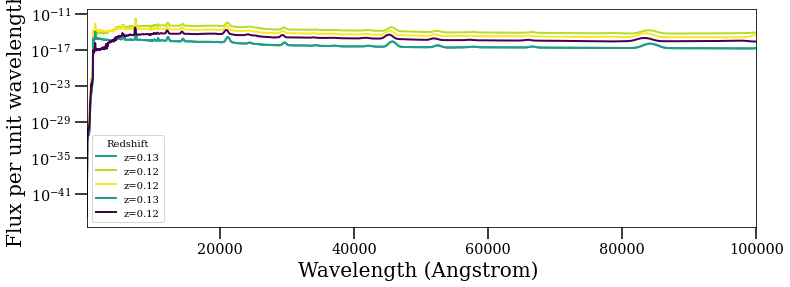

In [27]:
# plot_SED(sed_unscaled, wave_unred, match_redshift[0:20], config['painting_model']['wave_min'], config['painting_model']['wave_max'], "Random")
plot_SED(sed_unscaled, wave_unred, match_redshift[0:10], config['painting_model']['wave_min'], config['painting_model']['wave_max'], "Random")

## Painting Central

In [28]:

# ------------------------------------------------
# The rest of your photometric_bandpass code, etc.
# (unchanged from your script)
# ------------------------------------------------

#SPHEREx bands
def load_indiv_filter(filtfile, 
                      norm=True):
    
    bandpass_name = filtfile.split('.')[0].split('/')[-1]
    
    x = np.loadtxt(filtfile)
    nonz = (x[:,1] != 0.)
    bandpass_wav = x[nonz,0]*1e-4 ## um?
    bandpass_val = x[nonz,1]

    if norm:
        bandpass_val /= np.sum(bandpass_val)

    cenwav = np.dot(bandpass_wav, bandpass_val)
    # cenwav = np.dot(x[nonz,0], x[nonz,1])

    return bandpass_wav, bandpass_val, cenwav, bandpass_name


def load_sphx_filters(filtdir='data/spherex_filts/', 
                      to_um=True):

    ''' 
    Loads files, returns list of central wavelengths and list of wavelengths/filter responses. 
    Converts wavelengths to microns unless otherwise specified.
    '''

    bandpass_wavs, bandpass_vals, central_wavelengths, bandpass_names = [], [], [], []
    bband_idxs = np.arange(1, 7)
    
    for bandidx in bband_idxs:
        filtfiles = glob.glob(filtdir+'SPHEREx_band'+str(bandidx)+'*.dat')
        for filtfile in filtfiles:

            bandpass_wav, bandpass_val, cenwav, bandpass_name = load_indiv_filter(filtfile)
            bandpass_names.append(bandpass_name)

            bandpass_wavs.append(bandpass_wav)
            bandpass_vals.append(bandpass_val)
            central_wavelengths.append(cenwav)

    return np.array(central_wavelengths), np.array(bandpass_wavs), np.array(bandpass_vals), np.array(bandpass_names)



## SDSS bands

def load_indiv_filter_sdss(filtfile, 
                           norm=True):
    
    bandpass_name = filtfile.split('.')[0].split('/')[-1]
    
    x = np.loadtxt(filtfile)
    nonz = (x[:,1] != 0.)
    bandpass_wav = x[nonz,0]*1e-4 ## um?
    bandpass_val = x[nonz,1]

    if norm:
        bandpass_val /= np.sum(bandpass_val)

    cenwav = np.dot(bandpass_wav, bandpass_val)
    # cenwav = np.dot(x[nonz,0], x[nonz,1])

    return bandpass_wav, bandpass_val, cenwav, bandpass_name

def load_sdss_filters(filtdir='data/sdss_filts/', 
                      to_um=True):

    ''' 
    Loads files, returns list of central wavelengths and list of wavelengths/filter responses. 
    Converts wavelengths to microns unless otherwise specified.
    '''

    bandpass_wavs, bandpass_vals, central_wavelengths, bandpass_names = [], [], [], []
    bband_idxs = ['u', 'g', 'r', 'i', 'z']
    
    for bandidx in bband_idxs:
        filtfiles = glob.glob(filtdir+'SLOAN_SDSS.'+str(bandidx)+'*.dat')
        for filtfile in filtfiles:
            

            bandpass_wav, bandpass_val, cenwav, bandpass_name = load_indiv_filter_sdss(filtfile)
            bandpass_names.append(bandpass_name)

            bandpass_wavs.append(bandpass_wav)
            bandpass_vals.append(bandpass_val)
            central_wavelengths.append(cenwav)

    return np.array(central_wavelengths), np.array(bandpass_wavs), np.array(bandpass_vals), np.array(bandpass_names)



def load_survey_pickle(survey, 
                       all_filters_pickle):
    
    spherex_filter_pickle, lsst_filter_pickle, cosmos_filter_pickle, wise_filter_pickle, ls_filter_pickle, mass2_filter_pickle, f784_filter_pickle = all_filters_pickle
    
    
    if (survey=='LSST'):
        FILTER_NAME = lsst_filter_pickle
    elif (survey=='SPHEREx'):
        FILTER_NAME = spherex_filter_pickle
    elif (survey=='COSMOS'):
        FILTER_NAME = cosmos_filter_pickle
    elif (survey=='WISE'):
        FILTER_NAME = wise_filter_pickle
    elif (survey=='LEGACYSURVEY'):
        FILTER_NAME = ls_filter_pickle
    elif (survey=='2MASS'):
        FILTER_NAME = mass2_filter_pickle
    elif (survey=='F784'):
        FILTER_NAME = f784_filter_pickle
         
        
    else: 
        raise NotImplementedError("Filter specifications not included")
        
    with open(FILTER_NAME, 'rb') as f:
     central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = pickle.load(f)
    
    # print(survey, central_wavelengths)
    
    return central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names


def clip_bandpass_vals(bandpass_wavs, 
                       bandpass_vals):
    
    all_clip_bandpass_wav, all_clip_bandpass_vals = [], []

    for b in range(len(bandpass_wavs)):
        nonz_bandpass_val = (bandpass_vals[b] > 0)
        clip_bandpass_wav = bandpass_wavs[b][nonz_bandpass_val]
        clip_bandpass_vals = bandpass_vals[b][nonz_bandpass_val]
        all_clip_bandpass_wav.append(clip_bandpass_wav)
        all_clip_bandpass_vals.append(clip_bandpass_vals)

    return all_clip_bandpass_wav, all_clip_bandpass_vals


def sed_to_mock_phot(central_wavelengths, 
                     sed_um_wave, 
                     sed_mJy_flux, 
                     bandpass_wavs, 
                     bandpass_vals, 
                     interp_kind='linear', 
                     plot=True, 
                     clip_bandpass=True):
    
    # central wavelengths in micron
    if clip_bandpass:
        all_clip_bandpass_wav, all_clip_bandpass_vals = clip_bandpass_vals(bandpass_wavs, bandpass_vals)

    sed_interp = interp1d(sed_um_wave,
                          sed_mJy_flux,
                          kind=interp_kind,
                          bounds_error=False, 
                          fill_value = 0.0)

    band_fluxes = np.zeros_like(central_wavelengths)

    for b, bandpass_wav in enumerate(bandpass_wavs):
        # fluxes in mJy
        if clip_bandpass:
            band_fluxes[b] = np.dot(all_clip_bandpass_vals[b], sed_interp(all_clip_bandpass_wav[b]))
        else:
            band_fluxes[b] = np.dot(bandpass_vals[b], sed_interp(bandpass_wav))

    flux = 1e3*band_fluxes # band_fluxes in mJy. flux in uJy = 1e3 mJy
    appmag_ext = -2.5*np.log10(flux)+23.9 ## flux here should be in uJy. 

    if plot:

        wav_um = np.array(central_wavelengths)

        plt.figure(figsize=(12, 4))
        plt.title('sed uJy flux')
        plt.plot(sed_um_wave, 1e3*sed_mJy_flux, color='k', zorder=5, alpha=0.5)
        plt.scatter(wav_um, flux, color='r', label='bandpass-convolved fluxes', s=30)
        # plt.ylim(0, 1.2*np.max(flux))
        # plt.yscale('log')
        plt.xlim(0, 10)
        plt.xlabel('um', fontsize=16)
        plt.ylabel('uJy', fontsize=16)
        plt.tick_params(labelsize=14)
        plt.legend()
        plt.show()
        
    plt.close("all")

    return flux, appmag_ext, band_fluxes



def load_model_and_scalers(scaler_output_path):
    import pickle

    with open(scaler_output_path, 'rb') as f:
        scaler_output = pickle.load(f)
    
    return scaler_output

def unscale_sed(scaler_output, scaled_sed):
    model_output_log = scaler_output.inverse_transform(scaled_sed)
    sed_unscaled = 10**(model_output_log)
    
    return sed_unscaled
    

def photometric_bandpass(pcolor_all, # in Jy
                         wave_unnred, # in Ang
                         redshift_in, all_filter_pickle, wave_lims, plot_cond):

    lsst_mags = np.zeros(shape=(pcolor_all.shape[0], 6))
    spherex_mags = np.zeros(shape=(pcolor_all.shape[0], 102))
    cosmos_mags = np.zeros(shape=(pcolor_all.shape[0], 31))
    wise_mags = np.zeros(shape=(pcolor_all.shape[0], 7))
    ls_mags = np.zeros(shape=(pcolor_all.shape[0], 8))
    mass2_mags = np.zeros(shape=(pcolor_all.shape[0], 3))
    f784_mags = np.zeros(shape=(pcolor_all.shape[0], 2))
    
    
    scaler_output_path = './trained_painting_NNs/eline_output_scale_damp_central_noncentral_z10.pkl'    
    scaler_output = load_model_and_scalers(scaler_output_path)


    
    for galID in range(pcolor_all.shape[0]):


        # redsh = redshift_in[0, galID]
        redsh = redshift_in[galID]

        # wave_red_cuts = wave_unnred[:, np.where( (wave_unnred[0]>wave_lims[0]) & (wave_unnred[0]<wave_lims[1]) )][0, 0, :]*(1 + redsh)

        wave_mask = np.where( (wave_unnred>wave_lims[0]) & (wave_unnred<wave_lims[1]))
        
        wave_red_cuts = wave_unnred[wave_mask]*(1 + redshift_in[galID])
        
        sed_um_wave = wave_red_cuts*1e-4 ## wave_red_cuts in ang. 1 ang = 1e-4 um 
        # sed_mJy_flux = unscale(mag_test, scaler_y)[galID]*1e-3 #mJy
        
        # sed_mJy_flux =  pcolor_all[0, galID, :].T*1e3
        
        ####################################################################
        
        # print('pcolor_all: ', pcolor_all.shape) ## (1000000, 1963)
        sed_scaled = pcolor_all[galID, :].reshape(-1, 1).T  #### (1, 1963)
        # print('sed_scaled MinMax: ', sed_scaled.min(), sed_scaled.max()) ## (1, 1963)
        
        sed_unscaled = unscale_sed(scaler_output, sed_scaled)[0, wave_mask][0]
    
    
        
        sed_mJy_flux = sed_unscaled*1e3 ## sed_unscaled in Jy. 1 Jy = 1e3 mJy
        
        # print('sed_mJy_flux MinMax: ', sed_mJy_flux.min(), sed_mJy_flux.min()) ## (921,)?
        
        ####################################################################
        


        # central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = painting.load_sphx_filters(filtdir=spherex_filters_dir, to_um=True)
        central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_pickle('SPHEREx', all_filter_pickle)

        flux_spherex, appmag_ext_spherex, band_fluxes_spherex = sed_to_mock_phot(central_wavelengths, 
                                                         sed_um_wave, 
                                                         sed_mJy_flux, 
                                                         bandpass_wavs, 
                                                         bandpass_vals, 
                                                         interp_kind='linear', 
                                                         plot=False, 
                                                         clip_bandpass=True)


        # central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = painting.load_lsst_filters(filtdir=sdss_filters_dir, to_um=True)
        central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_pickle('LSST', all_filter_pickle)

        flux_lsst, appmag_ext_lsst, band_fluxes_lsst = sed_to_mock_phot(central_wavelengths, 
                                                         sed_um_wave, 
                                                         sed_mJy_flux, 
                                                         bandpass_wavs, 
                                                         bandpass_vals, 
                                                         interp_kind='linear', 
                                                         plot=plot_cond, 
                                                         clip_bandpass=True)





        central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_pickle('COSMOS', all_filter_pickle)

        flux_cosmos, appmag_ext_cosmos, band_fluxes_cosmos = sed_to_mock_phot(central_wavelengths, 
                                                         sed_um_wave, 
                                                         sed_mJy_flux, 
                                                         bandpass_wavs, 
                                                         bandpass_vals, 
                                                         interp_kind='linear', 
                                                         plot=False, 
                                                         clip_bandpass=True)

        central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_pickle('WISE', all_filter_pickle)

        flux_wise, appmag_ext_wise, band_fluxes_wise = sed_to_mock_phot(central_wavelengths, 
                                                         sed_um_wave, 
                                                         sed_mJy_flux, 
                                                         bandpass_wavs, 
                                                         bandpass_vals, 
                                                         interp_kind='linear', 
                                                         plot=False, 
                                                         clip_bandpass=True)

        central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_pickle('LEGACYSURVEY', all_filter_pickle)

        flux_ls, appmag_ext_ls, band_fluxes_ls = sed_to_mock_phot(central_wavelengths, 
                                                         sed_um_wave, 
                                                         sed_mJy_flux, 
                                                         bandpass_wavs, 
                                                         bandpass_vals, 
                                                         interp_kind='linear', 
                                                         plot=False, 
                                                         clip_bandpass=True)


        central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_pickle('2MASS', all_filter_pickle)

        flux_2mass, appmag_ext_2mass, band_fluxes_2mass = sed_to_mock_phot(central_wavelengths, 
                                                         sed_um_wave, 
                                                         sed_mJy_flux, 
                                                         bandpass_wavs, 
                                                         bandpass_vals, 
                                                         interp_kind='linear', 
                                                         plot=False, 
                                                         clip_bandpass=False)

        central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_pickle('F784', all_filter_pickle)

        flux_f784, appmag_ext_f784, band_fluxes_f784 = sed_to_mock_phot(central_wavelengths, 
                                                         sed_um_wave, 
                                                         sed_mJy_flux, 
                                                         bandpass_wavs, 
                                                         bandpass_vals, 
                                                         interp_kind='linear', 
                                                         plot=False, 
                                                         clip_bandpass=False)




        lsst_mags[galID] = appmag_ext_lsst
        spherex_mags[galID] = appmag_ext_spherex
        cosmos_mags[galID] = appmag_ext_cosmos
        wise_mags[galID] = appmag_ext_wise
        ls_mags[galID] = appmag_ext_ls
        mass2_mags[galID] = appmag_ext_2mass
        f784_mags[galID] = appmag_ext_f784
    

    # print('SPHEREx mags', spherex_mags.shape)
    return lsst_mags, spherex_mags, cosmos_mags, wise_mags, ls_mags, mass2_mags, f784_mags

In [29]:
import pickle 
from scipy.integrate import simps
from scipy.interpolate import interp1d as interp1d
import glob
import matplotlib.pylab as plt
import pickle


# Wave, filters, etc.
# wave_unred = load_wave_unred()
# wave_lims = [config['painting_model']['wave_min'], config['painting_model']['wave_max']]
wave_lims = [wave_min, wave_max]

spherex_filter_pickle = config['painting_model']['spherex_filter_pickle']
lsst_filter_pickle = config['painting_model']['lsst_filter_pickle']
cosmos_filter_pickle = config['painting_model']['cosmos_filter_pickle']
wise_filter_pickle = config['painting_model']['wise_filter_pickle']
ls_filter_pickle = config['painting_model']['legacysurvey_filter_pickle']
mass2_filter_pickle = config['painting_model']['mass2_filter_pickle']
f784_filter_pickle = config['painting_model']['f784_filter_pickle']
all_filters = [spherex_filter_pickle, lsst_filter_pickle, cosmos_filter_pickle,
                   wise_filter_pickle, ls_filter_pickle, mass2_filter_pickle, f784_filter_pickle]


In [30]:
spherex_filter_pickle

'/lcrc/project/cosmo_ai/nramachandra/Projects/Hydro_paint/watercolor/watercolor/data/filter_specifics/SPHEREx.pickle'

In [31]:
# sed_unscaled.shape, wave_unred.shape, z_chunk.shape

In [32]:
match_redshift.shape[0]

36067069

## Deployment of conv

In [33]:
np.random.seed(18)
rand_gal_idx = np.random.randint(low=0, high=match_redshift.shape[0], size=1000)
z_chunk = match_redshift[rand_gal_idx]
sed_unscaled = unscale_sed(scaler_output, sed_for_lc['SED'][rand_gal_idx])
print('REDSHIFT: ', z_chunk)
mags_tuple = photometric_bandpass(sed_unscaled*1e12, wave_unred, z_chunk, all_filters, wave_lims, False);
lsst_mags, spherex_mags, cosmos_mags, wise_mags, ls_mags, mass2_mags, f784_mags = mags_tuple
print(lsst_mags.min())

REDSHIFT:  [2.375 1.271 1.842 0.735 0.672 1.775 1.101 1.666 2.457 2.101 1.376 2.13
 0.809 0.239 1.623 3.269 1.503 0.754 0.909 2.934 1.631 1.204 2.028 3.315
 1.467 0.637 0.853 0.63  2.211 2.548 1.768 2.555 4.171 3.066 0.503 2.189
 1.709 1.217 2.522 1.021 2.126 1.796 3.074 1.092 3.309 1.678 3.136 2.639
 1.035 0.887 2.116 1.523 0.892 4.624 1.904 2.715 0.454 0.382 2.1   2.248
 1.349 2.295 1.012 1.853 1.509 1.553 0.277 1.072 1.135 0.877 2.496 2.371
 2.828 1.143 4.414 1.295 1.566 0.708 1.017 2.263 2.467 2.182 1.277 0.751
 3.01  3.766 0.599 2.8   0.826 1.37  1.264 1.39  2.25  4.26  4.299 3.343
 0.42  1.394 1.017 2.215 2.451 1.682 1.724 2.95  1.708 0.627 2.684 3.847
 1.919 2.576 0.921 1.636 1.429 1.35  1.194 1.311 1.594 3.203 1.395 3.037
 1.204 0.756 3.935 1.47  0.922 1.963 1.796 2.329 1.687 3.223 3.741 1.056
 2.053 2.468 2.695 2.444 1.303 1.733 0.296 2.912 1.974 1.098 0.329 0.83
 2.314 1.901 2.441 1.167 1.792 1.322 1.878 3.529 4.778 1.604 1.186 1.404
 2.156 2.043 1.917 2.574 1.132 0.731 5.088

/lcrc/project/cosmo_ai/nramachandra/Projects/tmp/ipykernel_2078815/3187313548.py:211: RuntimeWarning: overflow encountered in power
  sed_unscaled = 10**(model_output_log)
/lcrc/project/cosmo_ai/nramachandra/Projects/tmp/ipykernel_2078815/3187313548.py:211: RuntimeWarning: overflow encountered in power
  sed_unscaled = 10**(model_output_log)
/lcrc/project/cosmo_ai/nramachandra/Projects/tmp/ipykernel_2078815/3187313548.py:211: RuntimeWarning: overflow encountered in power
  sed_unscaled = 10**(model_output_log)
/lcrc/project/cosmo_ai/nramachandra/Projects/tmp/ipykernel_2078815/3187313548.py:261: RuntimeWarning: overflow encountered in multiply
  sed_mJy_flux = sed_unscaled*1e3 ## sed_unscaled in Jy. 1 Jy = 1e3 mJy
/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/env_jax_2025/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:641: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/lcrc/project/cosmo_ai/nramachandra/Proje

-15.629388809204102


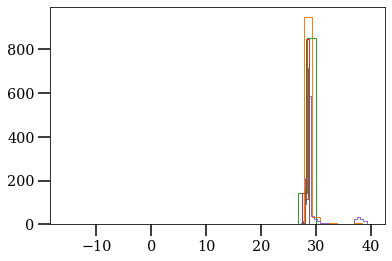

In [34]:
plt.hist(lsst_mags[:, 0], bins = 30, histtype='step');
plt.hist(lsst_mags[:, 1], bins = 30, histtype='step');
plt.hist(lsst_mags[:, 2], bins = 30, histtype='step');
plt.hist(lsst_mags[:, 3], bins = 30, histtype='step');
plt.hist(lsst_mags[:, 4], bins = 30, histtype='step');
plt.hist(lsst_mags[:, 5], bins = 30, histtype='step');


SHAPE (nSED, nWave):  (3419, 1963)


/lcrc/project/cosmo_ai/nramachandra/Projects/tmp/ipykernel_2078815/941904841.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  a[0, galid].set_ylim(0, 1.2*sed_uJy_flux[galid].max())
/lcrc/project/cosmo_ai/nramachandra/Projects/tmp/ipykernel_2078815/941904841.py:44: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  a[1, galid].set_ylim(0, 1.2*sed_uJy_flux[galid].max())


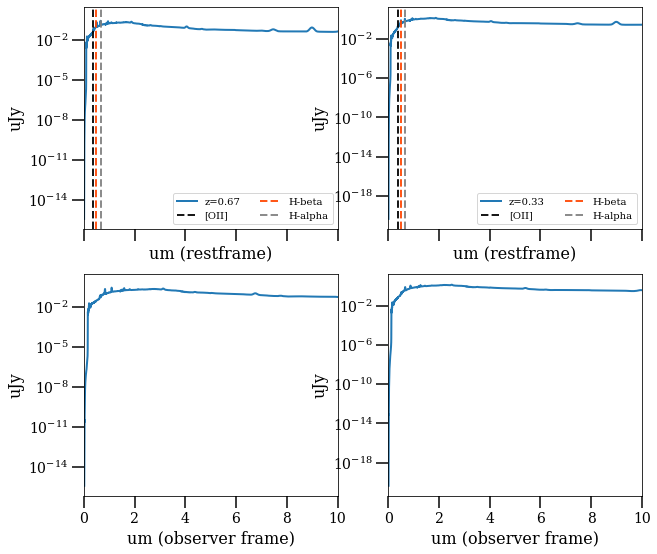

In [35]:
ifCentral = True
# Each rank saves its own output
homeDir = '/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/TrainingData/'
homeDir0 = 'Data/Damp_red_noncentrals_100k_z10/' if not ifCentral else 'Data/Damp_red_centrals_100k_z10/'


def load_from_data(outfile_num, rank):
    all_spec = np.load(f"{homeDir}{homeDir0}spec{outfile_num}_rank{rank}.npy") ## Jy
    all_spec_no_dust = np.load(f"{homeDir}{homeDir0}spec_no_dust{outfile_num}_rank{rank}.npy") 
    all_wave = np.load(f"{homeDir}{homeDir0}wave_spec{outfile_num}_rank{rank}.npy") ## Ang
    lhc_params = np.load(f"{homeDir}{homeDir0}redshift{outfile_num}_rank{rank}.npy")
    sfh = np.load(f"{homeDir}{homeDir0}sfh{outfile_num}_rank{rank}.npy")
    
    print('SHAPE (nSED, nWave): ', all_spec.shape)
    
    return all_spec, all_wave, lhc_params, sfh

def plot_sed(sed_ang_wave, sed_Jy_flux, redshift):
    
        num_gals = sed_ang_wave.shape[0]
    
        f, a = plt.subplots(2, num_gals, figsize=(5*num_gals, 9), sharex=True, sharey=False)
        # plt.suptitle('sed')
        for galid in range(num_gals):
            
            sed_uJy_flux = sed_Jy_flux*1e6 ## 1 Jy = 1e6 uJy
            sed_um_wave = sed_ang_wave*1e-4 ## 1 ang = 1e-4 um 
            sed_um_wave_rest = sed_um_wave[galid]/(1 + redshift[galid])
            
            a[0, galid].plot(sed_um_wave_rest, sed_uJy_flux[galid], alpha=0.99, label=r'z=%.2f'%redshift[galid])
            
            a[1, galid].plot(sed_um_wave[galid], sed_uJy_flux[galid], alpha=0.99, label=r'z=%.2f'%redshift[galid])

            # a[0].set_xscale('log')
            a[0, galid].set_yscale('log')

            # a[1].set_xscale('log')
            a[1, galid].set_yscale('log')

            a[0, galid].set_xlim(0, 10)
            a[1, galid].set_xlim(0, 10)

            a[0, galid].set_ylim(0, 1.2*sed_uJy_flux[galid].max())
            a[1, galid].set_ylim(0, 1.2*sed_uJy_flux[galid].max())

            # a[0].set_ylim(1e-5, 1e-1)

            # plt.ylabel('Flux per unit wavelength (Jy)', fontsize=16)
            # plt.xlabel(' Restframe Wavelength (Angstrom) ', fontsize=16)

            a[0, galid].axvline(x=3727*1e-4, label = '[OII]', linestyle='dashed', alpha=0.9, color='black')
            # plt.axvline(x=4050*1e-4, label = '[OIII]', linestyle='dashed', alpha=0.9, color='purple')
            a[0, galid].axvline(x=4861*1e-4, label = 'H-beta', linestyle='dashed', alpha=0.9, color='orangered')
            # plt.axvline(x=5007*1e-4, label = '[OIII]', linestyle='dashed', alpha=0.9, color='purple')
            a[0, galid].axvline(x=6563*1e-4, label = 'H-alpha', linestyle='dashed', alpha=0.9, color='gray')

            a[0, galid].set_xlabel('um (restframe)', fontsize=16)
            a[0, galid].set_ylabel('uJy', fontsize=16)
            a[1, galid].set_xlabel('um (observer frame)', fontsize=16)
            a[1, galid].set_ylabel('uJy', fontsize=16)
            
            a[0, galid].tick_params(labelsize=14)
            a[1, galid].tick_params(labelsize=14)
            a[0, galid].legend(ncol=2)
        
        
        plt.show()

all_spec, all_wave, lhc_params, sfh = load_from_data(outfile_num=42, rank=0)
sed_idx = np.random.randint(low=0, high=all_spec.shape[1], size=2)
plot_sed(all_wave[sed_idx], all_spec[sed_idx], lhc_params[sed_idx]);

In [36]:
wave_unred.min(), (all_wave[0]/(1 + lhc_params[0])).min()

(91.0, 91.0)

In [37]:
np.array([lhc_params[:2]])

array([[1.448, 8.168]])

In [38]:
all_spec[sed_idx]*1e2

array([[3.656e-20, 6.783e-20, 1.210e-19, ..., 1.674e-06, 1.676e-06,
        1.679e-06],
       [4.454e-25, 1.196e-24, 2.698e-24, ..., 8.045e-06, 8.057e-06,
        8.068e-06]])

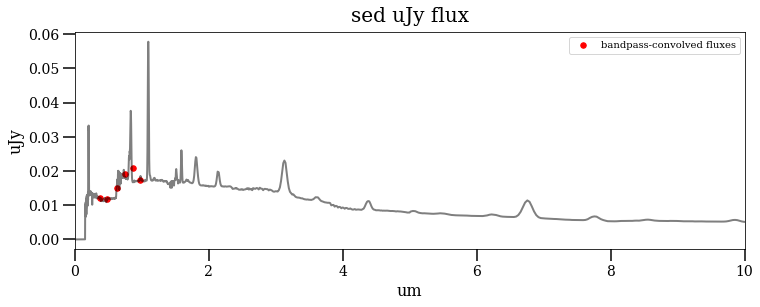

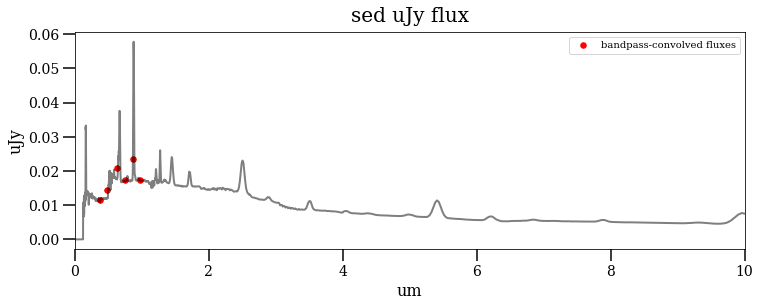

LSST MinMax:  27.976293563842773 28.734180450439453


In [39]:
mags_tuple = photometric_bandpass(all_spec[sed_idx]*1e1, all_wave[0]/(1 + lhc_params[0]), np.array(lhc_params[sed_idx]), all_filters, wave_lims, True)
lsst_mags, spherex_mags, cosmos_mags, wise_mags, ls_mags, mass2_mags, f784_mags = mags_tuple
print('LSST MinMax: ', lsst_mags.min(), lsst_mags.max())

In [40]:
wise_mags.min(), wise_mags.max()

(28.036701989642523, 29.258736671248016)

In [41]:
spherex_mags.min(), spherex_mags.max()

(27.364786979820778, 29.31402210766847)

In [42]:
print(spherex_mags.shape)

(2, 102)


In [43]:
wave_min

90

In [44]:
lsst_mags

array([[28.094, 28.724, 28.453, 28.299, 28.699, 28.196],
       [27.976, 28.5  , 28.094, 28.299, 28.734, 28.308]])